In [2]:
import json
from datetime import datetime
#!pip install tld
#!pip install dateparser
#!pip install geoip2
#!pip install trackingprotection-tools
import dateparser
import pytz
import geoip2.database 
import os
import pandas as pd
from tld import get_fld
import matplotlib.pyplot as plt
import trackingprotection_tools
import statistics


### Datasets

In [8]:

directory = 'crawl_data'

#list of jsons paths
json_list = []

#filtered noop and accept
noop_list = []
accept_list = []

entity_list = json.loads(open('domain_map.json',  encoding="utf8").read())

#iterate over every file get the json files and put the json path into the json_list
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f): 
        if '.json' in f:
            json_list.append(f)

for crawl in json_list:
    #load the json
    with open(crawl, "r") as data:
        crawl_data = json.load(data)
    #check wether it is an 'accept'or a 'noop'
    if 'accept' in crawl:
        accept_list.append(crawl_data)
    elif 'noop' in crawl:
        noop_list.append(crawl_data)



### 1: Number of crawl failures

In [9]:
#create a table for the crawl failures
empty_failure_table = { 'Error type': ['Page load timeout','DNS error','Consent click error'],
         'Crawl-accept':[0,0,0],
         'Crawl-noop':[0,0,0]}

failure_table  = pd.DataFrame(empty_failure_table).set_index('Error type')

#check if there was a failure
def check_failure (data, crawl_type):
    if data['consentClickError']:
        current_value = failure_table[crawl_type]['Consent click error'] 
        failure_table[crawl_type]['Consent click error'] = current_value +1
    elif data['pageLoadTimeout']:
        current_value = failure_table[crawl_type]['Page load timeout']
        failure_table[crawl_type]['Page load timeout'] = current_value +1
    elif data['dnsError']:
        current_value = failure_table[crawl_type]['DNS error'] 
        failure_table[crawl_type]['DNS error'] = current_value +1


#fill in the  crawl failure table
def fill_table (noop_list ,accept_list):
    #loop throught
    for accept in accept_list:
        #check if there was a failure
        check_failure(accept,'Crawl-accept' )
    for noop in noop_list:
        check_failure(noop, 'Crawl-noop')
            
            
##fill in the failure table
fill_table(noop_list,accept_list)

print (failure_table)
    

                     Crawl-accept  Crawl-noop
Error type                                   
Page load timeout               0           0
DNS error                       1           1
Consent click error             1           0


###  2: Comparison Crawl-accept vs Crawl-noop (box plot)


##### a. Page load time

[0, 8847, 2264, 0, 2846, 1967, 2486, 3507, 6479, 4789]
[0, 6248, 2283, 0, 2585, 1969, 2740, 4524, 3159, 5668]


<Axes: >

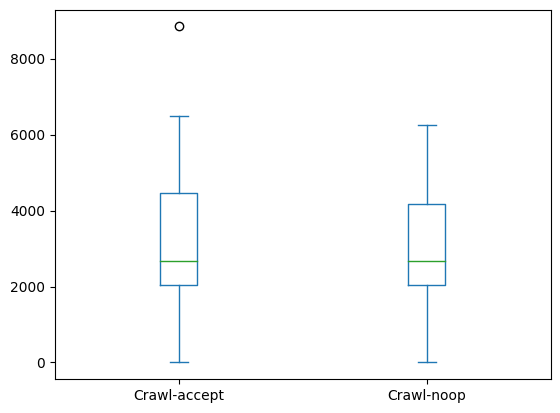

In [10]:
load_time_accept = []
load_time_noop = []

def page_load_time(data):
    time = data['pageLoadEndTimestamp'] - data['pageLoadStartTimestamp'] 
    return (time)

def fill_page_load_lists(accept_list,noop_list ):
    for crawl_accept in accept_list:
        load_time_accept.append(page_load_time(crawl_accept))
    for crawl_noop in noop_list:
        load_time_noop.append(page_load_time(crawl_noop))


fill_page_load_lists(accept_list,noop_list )
print (load_time_accept )
print (load_time_noop )
page_load_time_boxplot = { 'Crawl-accept': load_time_accept , 'Crawl-noop': load_time_noop}


df = pd.DataFrame(page_load_time_boxplot)
df.plot(kind='box')


##### b. Number of requests


[0, 0, 1, 0, 0, 21, 8, 3, 10, 191]
[0, 0, 1, 0, 0, 6, 8, 1, 9, 57]


<Axes: >

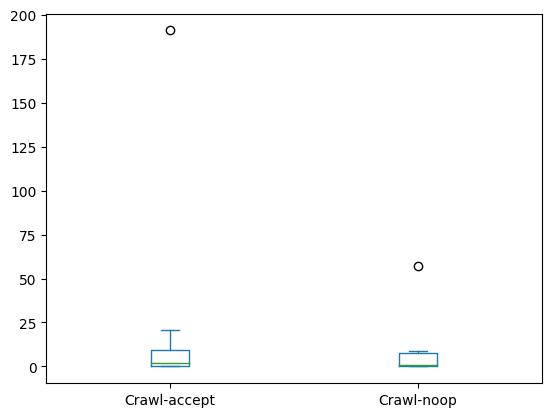

In [11]:
nr_request_data_noop = []
nr_request_data_accept = [] 

def num_requests(data):
    return len(data['httpRequests'])

def fill_request_lists(accept_list,noop_list):
    for crawl_accept in accept_list:
        nr_request_data_accept.append(num_requests(crawl_accept))
    for crawl_noop in noop_list:
        nr_request_data_noop.append(num_requests(crawl_noop))

fill_request_lists(accept_list,noop_list)
request_boxplot = { 'Crawl-accept': nr_request_data_accept, 'Crawl-noop': nr_request_data_noop}

print (nr_request_data_accept)
print (nr_request_data_noop)

df = pd.DataFrame(request_boxplot)
df.plot(kind='box')


    

##### c. Number of distinct third parties

[0, 0, 0, 0, 0, 0, 0, 0, 0, 7]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 6]


<Axes: >

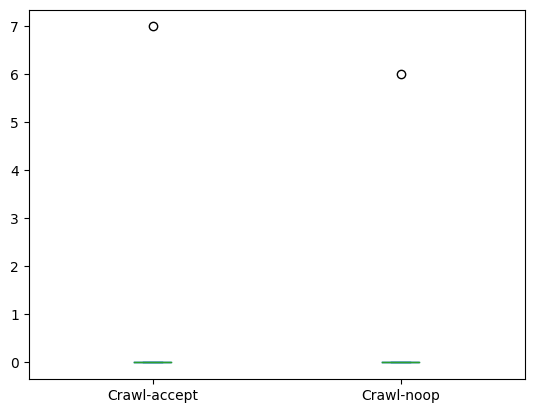

In [12]:
nr_distinct_third_party_accept = []
nr_distinct_third_party_noop = []


def distinct_third_parties(requests,main_domain):
    third_parties = set()
    for request in requests:
        url = request['requestURL']
        req_domain = get_fld(url)
        if req_domain not in main_domain:
            third_parties.add(req_domain)
    return len(third_parties)  
        

def fill_distinct_list(accept_list,noop_list):
    for crawl_accept in accept_list:
        website_domain = crawl_accept['domain'] 
        nr_distinct_third_party_accept.append(distinct_third_parties(crawl_accept['httpRequests'], website_domain)) 
    for crawl_noop in noop_list:
        website_domain = crawl_noop['domain'] 
        nr_distinct_third_party_noop.append(distinct_third_parties(crawl_noop['httpRequests'], website_domain))

fill_distinct_list(accept_list,noop_list)
third_party_boxplot = { 'Crawl-accept': nr_distinct_third_party_accept , 'Crawl-noop': nr_distinct_third_party_noop}

print(nr_distinct_third_party_accept)
print (nr_distinct_third_party_noop)

df = pd.DataFrame(third_party_boxplot)
df.plot(kind='box')

## er zijn alleen maar requests van hetzelfde domain in de huidige data

##### d. Number of distinct tracker domains


In [13]:
#per website
nr_tracker_domains_accept = []
nr_tracker_domains_noop = []

tracker_domains_accept = []
tracker_domains_noop =[]

## using Mozilla’s trackingprotection-tools library. to check wether the domain is a tracker
def blocklisted_tracker(domain):
    return trackingprotection_tools.DisconnectParser('services.json').should_block(domain)


def fill_tracker_domains_cookies(noop_list, accept_list):
    for crawl_accept in accept_list:
        distinct_cookies = []
        if crawl_accept['cookies']:
            for cookie in crawl_accept['cookies']:
                if blocklisted_tracker(cookie['domain']):
                    if cookie['domain'] not in distinct_cookies:
                        distinct_cookies.append(cookie['domain']) 
        tracker_domains_accept.append(distinct_cookies)
        nr_tracker_domains_accept.append(len(distinct_cookies))
    for crawl_noop in noop_list:
        distinct_cookies = []
        if crawl_noop['cookies']:
            for cookie in crawl_noop['cookies']:
                if blocklisted_tracker(cookie['domain']):
                    if cookie['domain'] not in distinct_cookies:
                        distinct_cookies.append(cookie['domain']) 
        tracker_domains_noop.append(distinct_cookies)
        nr_tracker_domains_noop.append(len(distinct_cookies))


#fill_tracker_domains(noop_list, accept_list)  
fill_tracker_domains_cookies(noop_list, accept_list)



distinct_tracker_domain_boxplot = { 'Crawl-accept': nr_tracker_domains_accept, 'Crawl-noop': nr_tracker_domains_noop}

print (nr_tracker_domains_accept)
print(nr_tracker_domains_noop)

df = pd.DataFrame(distinct_tracker_domain_boxplot)
df.plot(kind='box')

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 172: character maps to <undefined>

##### e. Number of distinct tracker entities/companies

In [14]:
#per website
nr_distinct_tracker_entities_accept = []
nr_distinct_tracker_entities_noop = []


def fill_distinct_entities(domains_accept, domains_noop):
    for website in domains_accept:
        distinct_entities = []
        for cookie in website:
            if cookie in entity_list:
                if entity_list[cookie]['displayName'] not in distinct_entities:
                    distinct_entities.append(entity_list[cookie]['displayName'])
        nr_distinct_tracker_entities_accept.append(len(distinct_entities))
    for website in domains_noop:
        distinct_entities = []
        for cookie in website:
            if cookie in entity_list:
                if entity_list[cookie]['displayName'] not in distinct_entities:
                    distinct_entities.append(entity_list[cookie]['displayName'])
        nr_distinct_tracker_entities_noop.append(len(distinct_entities))
    

fill_distinct_entities(tracker_domains_accept,tracker_domains_noop)


distinct_entity_domain_boxplot = { 'Crawl-accept': nr_distinct_tracker_entities_accept, 'Crawl-noop': nr_distinct_tracker_entities_noop}


print (nr_distinct_tracker_entities_accept)
print (nr_distinct_tracker_entities_noop)

df = pd.DataFrame(distinct_entity_domain_boxplot)
df.plot(kind='box')

[0, 0, 0, 0, 0]
[]


ValueError: All arrays must be of the same length

### 3: Comparison Crawl-accept vs Crawl-noop (table)

In [15]:
#data
nr_request_data_noop = []
nr_request_data_accept = [] 

def calc_median(data):
    if data == []:
        return 0
    else:
        return statistics.median(data)
    

page_load_time = [min(load_time_accept, default=0),calc_median(load_time_accept),max(load_time_accept,default=0),min(load_time_noop, default=0)
                  ,calc_median(load_time_noop),max(load_time_noop, default=0)]
                  

number_of_requests= [min(nr_request_data_accept,default=0), calc_median(nr_request_data_accept),max(nr_request_data_accept,default=0)
                     ,min(nr_request_data_noop,default=0),calc_median(nr_request_data_noop),max(nr_request_data_noop, default=0)]
                     

number_of_distinct_third_parties= [min(nr_distinct_third_party_accept,default=0),calc_median(nr_distinct_third_party_accept)
                                   ,max(nr_distinct_third_party_accept, default=0),min(nr_distinct_third_party_noop,default=0),
                                   calc_median(nr_distinct_third_party_noop),max(nr_distinct_third_party_noop, default=0)]
                                  

number_of_distinct_tracker_domains = [min(nr_tracker_domains_accept,default=0),calc_median(nr_tracker_domains_accept),
                                      max(nr_tracker_domains_accept, default=0),min(nr_tracker_domains_noop, default=0),
                                      calc_median(nr_tracker_domains_noop),max(nr_tracker_domains_noop, default=0)]
                                      

number_ofdistinct_tracker_companies = [min(nr_distinct_tracker_entities_accept,default=0),calc_median(nr_distinct_tracker_entities_accept)
                                       ,max(nr_distinct_tracker_entities_accept, default=0), min(nr_distinct_tracker_entities_noop, default=0)
                                       ,calc_median(nr_distinct_tracker_entities_noop),max(nr_distinct_tracker_entities_noop, default=0)]


comparison_data = [page_load_time,number_of_requests,number_of_distinct_third_parties,number_of_distinct_tracker_domains,number_ofdistinct_tracker_companies]
df = pd.DataFrame(comparison_data,
                  index=pd.Index(['Page load time', 'Number of requests', 'Number of distinct third parties', 'Number of distinct tracker domains'
                                  , 'Number of distinct tracker entities/companies' ], name=''),
                  columns=pd.MultiIndex.from_product([['Crawl-accept', 'Crawl-noop'],['Min', 'Median', 'Max']], names=['', 'Metric']))

df

Crawl-accept                \
Metric                                                 Min  Median   Max   
                                                                           
Page load time                                           0  2666.0  8847   
Number of requests                                       0     0.0     0   
Number of distinct third parties                         0     0.0     7   
Number of distinct tracker domains                       0     0.0     0   
Number of distinct tracker entities/companies            0     0.0     0   

                                              Crawl-noop                
Metric                                               Min  Median   Max  
                                                                        
Page load time                                         0  2662.5  6248  
Number of requests                                     0     0.0     0  
Number of distinct third parties                       0     0.0     6  
Number of distinct tracker domains                     0     0.0     0  
Number of distinct tracker entities/companies          0     0.0     0

### 4: Table of the Ten most prevalent third-party domains 
##### (based on the number of distinct websites where the third party is present)

In [17]:
cookies = {}
# domain : (nr. of occurrences in accept, nr. of occurrences in noop)

is_tracker = {}
# domain : "Yes"/"No"

def increment_accept(tuple):
    return ((tuple[0]+1, tuple[1]))

def increment_noop(tuple):
    return ((tuple[0], tuple[1]+1))

def add_distinct_cookies(list, mode):
    for entry in list:
        if entry['cookies']:
            entry_cookies = []
            for cookie in entry['cookies']:
                if cookie['domain'] not in entry_cookies:
                    if mode == 'accept':
                        cookies[cookie['domain']] = increment_accept(cookies.get(cookie['domain'], (0,0)))
                    elif mode == 'noop':
                        cookies[cookie['domain']] = increment_noop(cookies.get(cookie['domain'], (0,0)))
                    entry_cookies.append(cookie['domain'])

add_distinct_cookies(accept_list, 'accept')
add_distinct_cookies(noop_list, 'noop')

top10 = sorted(cookies.items(), key=lambda x:-x[1][0])[:10]

with open("entities.json", "r", encoding="utf8") as tracker_file:
    file_contents = tracker_file.read()
trackers = json.loads(file_contents)['entities']
for tracker in trackers:
    if trackers[tracker]['properties']:
        for domain in trackers[tracker]['properties']:
            for item in top10:
                if domain == item[0]:
                    is_tracker[domain] = "Yes"

empty_third_party_table = {'Third-party domain' : [x[0] for x in top10], 
                           'Crawl-accept':[0]*len(top10),
                           'Crawl-noop': [0]*len(top10),
                           'isTracker?': ["No"]*len(top10)}

# Disable chained assignment warnings
pd.options.mode.chained_assignment = None

third_party_table = pd.DataFrame(empty_third_party_table).set_index('Third-party domain')
for entry in top10:
    third_party_table['Crawl-accept'][entry[0]] = entry[1][0]
    third_party_table['Crawl-noop'][entry[0]] = entry[1][1]
    third_party_table['isTracker?'][entry[0]] = is_tracker.get(entry[0], "No")

print(third_party_table)
    

{'.google.com': (1, 1), '.instagram.com': (1, 0), 'www.microsoft.com': (1, 0), '.microsoft.com': (1, 0), '.twitter.com': (1, 1), '.youtube.com': (1, 1)}
                    Crawl-accept  Crawl-noop isTracker?
Third-party domain                                     
.google.com                    1           1         No
.instagram.com                 1           0         No
www.microsoft.com              1           0         No
.microsoft.com                 1           0         No
.twitter.com                   1           1         No
.youtube.com                   1           1         No


### 5: Scatter plot of:
##### Y: Number of distinct tracker domains
##### VS
##### X: Website’s Tranco rank
###### (for each crawl)

[[1, 0], [2, 0], [3, 0], [4, 0], [6, 0], [7, 0], [8, 0], [9, 0], [96167, 0]]


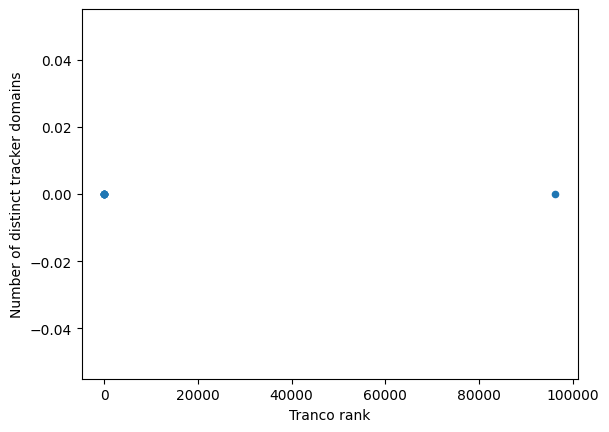

In [19]:
tranco = {}
distinct_trackers = {}

def check_if_tracker(cookie_domain):
    for tracker in trackers:
        if trackers[tracker]['properties']:
            for domain in trackers[tracker]['properties']:
                if domain == cookie_domain:
                    return True
    return False    

for entry in accept_list:
    distinct_trackers[entry['domain']] = 0
    if entry['cookies']:
        entry_cookies = []
        for cookie in entry['cookies']:
            if cookie['domain'] not in entry_cookies:
                entry_cookies.append(cookie['domain'])
                if check_if_tracker(cookie['domain']):
                    distinct_trackers[entry['domain']] += 1
    
import csv   
with open('top-1m.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        for entry in accept_list:
            if row[1] == entry['domain']:
                tranco[entry['domain']] = row[0]
    
tranco_tracker = []
for entry in tranco:
    tranco_tracker.append([int(tranco[entry]), int(distinct_trackers[entry])])
    
df = pd.DataFrame(tranco_tracker, columns=['Tranco rank', 'Number of distinct tracker domains'])
ax1 = df.plot.scatter(x='Tranco rank', y='Number of distinct tracker domains')

### 6: Table of the Top ten tracker entities (companies) and their prevalence
##### (based on the number of distinct websites where the entity is present). Similar to the table in 4, but should only contain tracker entities).

In [22]:
tracker_entities = {}

with open("domain_map.json", "r", encoding="utf8") as domain_map_file:
    domain_map = json.loads(domain_map_file.read())
    for cookie in cookies:
        if cookie in domain_map:
            tracker_entities[domain_map[cookie]['displayName']] = tracker_entities.get(domain_map[cookie]['displayName'], 0) + 1

top10_trackers = sorted(tracker_entities.items(), key=lambda x:-x[1])[:10]
    
empty_tracker_table = {'Entity name' : [x[0] for x in top10_trackers],
                       'Number of distinct websites': [0]*len(top10_trackers)}
tracker_table = pd.DataFrame(empty_tracker_table).set_index('Entity name')
for entry in top10_trackers:
    tracker_table['Number of distinct websites'][entry[0]] = entry[1]
    
print(tracker_table)

Empty DataFrame
Columns: [Number of distinct websites]
Index: []


### 7: Find the three cookies with the longest lifespans **for each crawl**
##### Add a separate table for each crawl having the following columns (see assignment). Only include the first 5 characters of the Value attribute.

In [37]:
import datetime

def print_tables(entry_list):
    empty_top3_cookie_data_table = {'Name' : [""],
                                    'Value' : [""],
                                    'Domain' : [""],
                                    'Path' : [""],
                                    'Expires' : [""],
                                    'Size' : [0],
                                    'HttpOnly' : [""],
                                    'Secure' : [""],
                                    'SameSite' : [""],
                                    }
    top3_cookie_data_table = pd.DataFrame(empty_top3_cookie_data_table).set_index('Name')
    for entry in entry_list:
        top3_cookie_data_table.sort_values(by=['Expires'], ascending=False, inplace=True)
        if entry['cookies']:
            empty_cookie_data_table = {'Name' : [cookie['name'] for cookie in entry['cookies']],
                                    'Value' : [""]*len(entry['cookies']),
                                    'Domain' : [""]*len(entry['cookies']),
                                    'Path' : [""]*len(entry['cookies']),
                                    'Expires' : [""]*len(entry['cookies']),
                                    'Size' : [0]*len(entry['cookies']),
                                    'HttpOnly' : [""]*len(entry['cookies']),
                                    'Secure' : [""]*len(entry['cookies']),
                                    'SameSite' : [""]*len(entry['cookies']),
                                    }
            cookie_data_table = pd.DataFrame(empty_cookie_data_table).set_index('Name')
            for cookie in entry['cookies']:
                cookie_data_table['Value'][cookie['name']]      = cookie['value'][:5]
                cookie_data_table['Domain'][cookie['name']]     = cookie['domain']
                cookie_data_table['Path'][cookie['name']]       = cookie['path']
                if isinstance(cookie['expiry'], int):
                    secs = int(cookie['expiry']) / 100
                    cookie_data_table['Expires'][cookie['name']]    = datetime.datetime.fromtimestamp(secs).strftime('%Y-%m-%d %H:%M:%S')
                cookie_data_table['Size'][cookie['name']]       = len(cookie['value'])
                cookie_data_table['HttpOnly'][cookie['name']]   = cookie['httpOnly']
                cookie_data_table['Secure'][cookie['name']]     = cookie['secure']
                cookie_data_table['SameSite'][cookie['name']]   = cookie['sameSite']
            cookie_data_table.sort_values(by=['Expires'], ascending=False, inplace=True)
            top3_cookie_data_table = pd.concat([top3_cookie_data_table.head(3), cookie_data_table.head(3)])
    print(top3_cookie_data_table.head(3))

print_tables(accept_list)
print_tables(noop_list)


          Value          Domain Path              Expires  Size HttpOnly  \
Name                                                                       
mid       ZHtLE  .instagram.com    /  2515-02-28 23:38:00    28    False   
ig_did    33C16  .instagram.com    /  2515-02-28 23:38:00    36     True   
guest_id  v1%3A    .twitter.com    /  2515-01-19 23:31:20    23    False   

         Secure SameSite  
Name                      
mid        True      Lax  
ig_did     True      Lax  
guest_id   True     None  
               Value        Domain Path              Expires  Size HttpOnly  \
Name                                                                          
guest_id       v1%3A  .twitter.com    /  2515-01-19 23:07:40    23    False   
CONSENT        PENDI   .google.com    /  2515-01-13 01:53:00    11    False   
__Secure-ENID  12.SE   .google.com    /  2514-11-30 20:56:00   177     True   

              Secure SameSite  
Name                           
guest_id        True    

### 8: Find the three requests with the most cookies **for each crawl**

### 9: Identify ten most common cross-domain HTTP redirection pairs 
#### that involve a tracker domain either in the source or the target(or both)

### 10: Capture the Images drawn by the canvas fingerprinting scripts
#### Create a table (see assignment)